# Training (1D)

In [1]:
import torch
import warnings
import torch.nn.functional as F
import io
import torchaudio
import torchvision
import numpy as np
import random
import PIL
from datasets import load_dataset
from torchvision.transforms import ToPILImage
from IPython.display import display, Audio, Image, update_display, HTML
from fastprogress.fastprogress import master_bar, progress_bar
from walloc import walloc
from itertools import combinations

In [2]:
device = "cuda:3"
class Config: pass
config = Config()
config.batch_size = 32
config.num_workers = 24
config.grad_accum_steps = 1
config.plot_update = 64
config.patience = 64
config.min_lr = 1e-7
config.max_lr = 3e-5
config.warmup_steps = 5000
config.weight_decay = 0.
config.epochs = 30
config.epoch_len = 10000
config.ϕ = 0.

config.audio_length = 2**19
config.channels=2
config.J = 8
config.Ne = None
config.Nd = 768
config.latent_dim = 108
config.latent_bits = 8
config.lightweight_encode = True
config.post_filter = True

In [3]:
train_dataset = load_dataset("danjacobellis/musdb_segments", split="train")
valid_dataset = load_dataset("danjacobellis/musdb_segments", split="validation")

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [4]:
mixing_weights = []

# Original mixture
mixing_weights.append(torch.ones(4))

# Amplify two channels, attenuate two
for indices in combinations(range(4), 2):
    weights = torch.full((4,), 0.5)
    weights[list(indices)] = 1.5
    mixing_weights.append(weights)

# Combinations of 3 channels (set to 1.0), one channel set to 0.0
for indices in combinations(range(4), 3):
    weights = torch.zeros(4)
    weights[list(indices)] = 1.0
    mixing_weights.append(weights)

# Combinations of 2 channels (set to 1.0), others set to 0.0
for indices in combinations(range(4), 2):
    weights = torch.zeros(4)
    weights[list(indices)] = 1.0
    mixing_weights.append(weights)

# Combinations of 1 channel
for index in range(4):
    weights = torch.zeros(4)
    weights[index] = 1.0
    mixing_weights.append(weights)

In [5]:
L = config.audio_length
C = config.channels
crop = torchvision.transforms.RandomCrop((4, L))
center_crop = torchvision.transforms.CenterCrop((1, L))
def collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, C, L), dtype=torch.float)
    for i_sample, sample in enumerate(batch):
        xi = torch.zeros((C,4,2**21), dtype=torch.int16)
        for i_instr, instr in enumerate(['vocal', 'bass', 'drums', 'other']):
            audio, fs = torchaudio.load(sample[f'audio_{instr}']['bytes'], normalize=False)
            xi[:,i_instr,:] = audio
        xi = crop(xi).to(torch.float)
        w = random.choice(mixing_weights).view(1, -1, 1)
        xi = (w*xi).sum(dim=1)
        xi = xi - xi.mean()
        max_abs = xi.abs().max()
        xi = xi / (max_abs + 1e-8)
        xi = xi/2
        # if random.random() < 0.5:
        #     xi = -xi
        # if random.random() < 0.5:
        #     xi = xi.flip(0)
        x[i_sample,:,:] = xi
    return x

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, C, L), dtype=torch.float)
    for i_sample, sample in enumerate(batch):
        xi = torch.zeros((C, 1, 2**21), dtype=torch.int16)
        audio_mix, fs = torchaudio.load(sample['audio_mix']['bytes'], normalize=False)
        xi[:, 0, :] = audio_mix
        xi = center_crop(xi).to(torch.float)
        xi = xi.squeeze(1)
        xi = xi - xi.mean()
        max_abs = xi.abs().max()
        xi = xi / (max_abs + 1e-8)
        xi = xi / 2
        x[i_sample, :, :] = xi
    return x

In [6]:
def make_spectrogram(X):
    X = spectrogram(X).log()
    X = X - X.mean()
    X = X/X.std()
    X = X/3
    X = X.clamp(-0.5,0.5)
    X = X + 0.5
    return ToPILImage()(X)

In [7]:
valid_batch = valid_dataset[200:201]
valid_batch = [dict(zip(valid_batch.keys(), values)) for values in zip(*valid_batch.values())]
x_valid = valid_collate_fn(valid_batch).to(device)

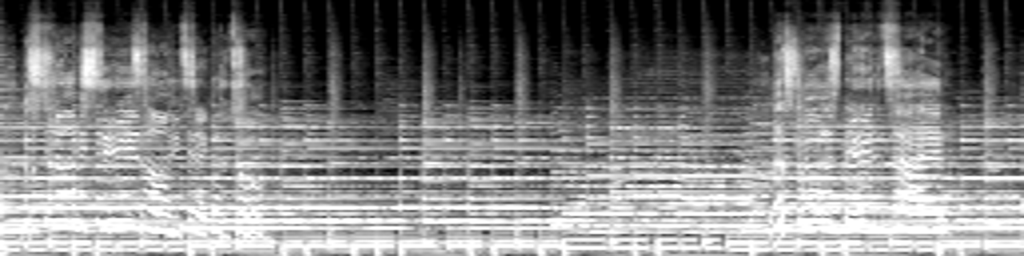

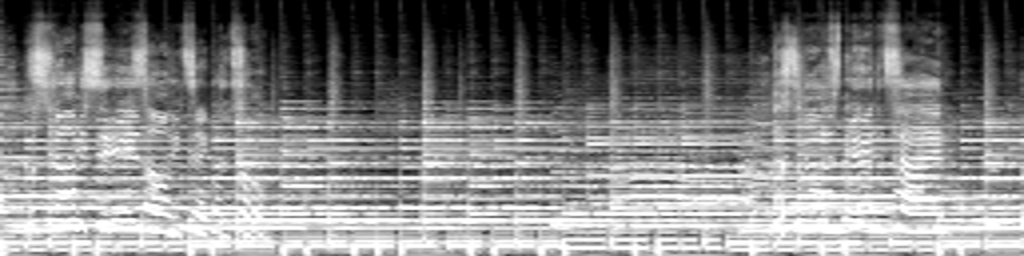

In [8]:
spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_fft=4096,
).to(device)
SG = make_spectrogram(x_valid[0,0].to(device))
display(SG.resize((1024,256)).transpose(method=PIL.Image.FLIP_TOP_BOTTOM))
SG = make_spectrogram(x_valid[0,1].to(device))
display(SG.resize((1024,256)).transpose(method=PIL.Image.FLIP_TOP_BOTTOM))

In [9]:
Audio(x_valid.to("cpu").numpy()[0],rate=44100)

In [10]:
codec = walloc.Codec1D(
    channels=config.channels,
    J=config.J,
    Ne=config.Ne,
    Nd=config.Nd,
    latent_dim=config.latent_dim,
    latent_bits=config.latent_bits,
    lightweight_encode=config.lightweight_encode,
    post_filter=config.post_filter
).to(device)

optimizer = torch.optim.AdamW(
    params=codec.parameters(),
    weight_decay=config.weight_decay,
    lr = config.min_lr
)

sum(p.numel() for p in codec.parameters())/1e6

/home/dgj335/.local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


16.346074

In [11]:
def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(config.max_lr) - np.log10(config.min_lr))
    angle =  np.pi * i_step / (config.warmup_steps//config.plot_update)
    log_lr = np.log10(config.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/config.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=config.patience,
    threshold=1e-5,
    min_lr=config.min_lr
)

/home/dgj335/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/dgj335/.local/lib/python3.10/site-packages/pytorch_wavelets/dwt/lowlevel.py:253: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  y = F.conv_transpose2d(lo, g0, stride=s, groups=C) + \
/home/dgj335/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered inte

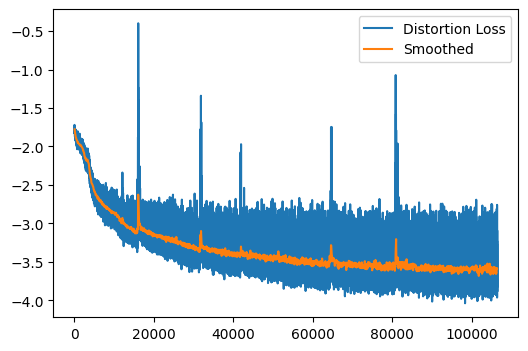

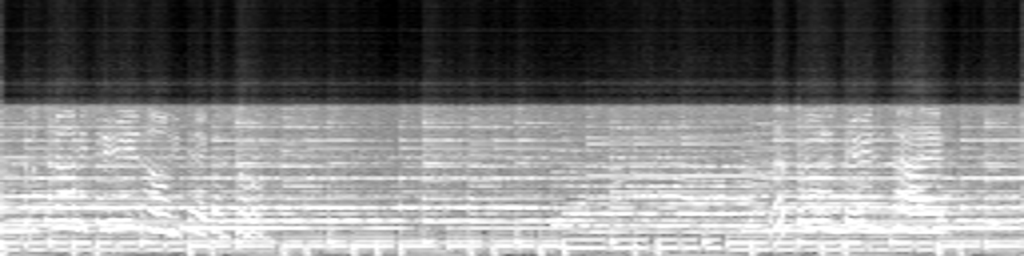

In [ ]:
dist_losses, rate_losses = [], []
learning_rates = [optimizer.param_groups[0]['lr']]
img_displays = []
text_display = None
codec.train()
optimizer.zero_grad()
mb = master_bar(range(config.epochs))
mb.names = ['Distortion Loss', 'Smoothed']
i_step = 0
for i_epoch in mb:
    sampler = torch.utils.data.RandomSampler(
        train_dataset,
        replacement=True,
        num_samples=config.epoch_len*config.batch_size
    )
    dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        sampler=sampler,
        drop_last=True,
        collate_fn=collate_fn
    )
    
    for i, x in enumerate(progress_bar(dataloader, parent=mb)):
        x = x.to(device)
        _, mse_loss, tf_loss = codec(x)
        dist_loss = mse_loss + config.ϕ*tf_loss
        dist_losses.append(np.log10(dist_loss.item()))
        loss = dist_loss
        loss.backward()
        if (i + 1) % config.grad_accum_steps == 0: 
            optimizer.step()
            optimizer.zero_grad()
        
        # plotting and lr scheduler
        if len(dist_losses) % config.plot_update == 0:
            plot_n = len(dist_losses) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(dist_losses).reshape(plot_n, -1).mean(dim=1)
            dist_x = range(len(dist_losses))
            dist_y = dist_losses
            mb.update_graph([[dist_x, dist_y],[smoothed_x, smoothed_y]])
            mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

            # lr scheduler
            if i_step < config.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])

            with torch.no_grad():
                codec.eval()
                y_valid, _, _ = codec(x_valid)
                torchaudio.save(f"valid_{device}.wav", src=y_valid[0].to("cpu"), sample_rate=44100)
                buffer = io.BytesIO()
                make_spectrogram(y_valid[0,0]).resize((1024,256)).transpose(method=PIL.Image.FLIP_TOP_BOTTOM).save(buffer, format="PNG")
                codec.train()
            buffer.seek(0)
            if len(img_displays) == 0:
                img_displays.append(display(Image(buffer.read()), display_id=True))
            else:
                update_display(Image(buffer.read()), display_id=img_displays[0].display_id)
                
        i_step+=1
        
    torch.save({
        'model_state_dict': codec.state_dict(),
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'dist_losses': dist_losses,
        'config': config
    }, f"log_{device}.pth")

In [13]:
from IPython.display import display, Image, update_display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

In [14]:
torch.save({
    'model_state_dict': codec.state_dict(),
    'config': config
}, "../../hf/walloc/Stereo_Li_108c_test2.pth")

In [15]:
with torch.no_grad():
    codec.eval()
    y_valid, td_loss, tf_loss = codec(x_valid)
    X = codec.wavelet_analysis(x_valid,codec.J)
    Y = codec.wavelet_analysis(y_valid,codec.J)
    Z = codec.encoder[:1](Y)
    Z2 = codec.encoder(Y)

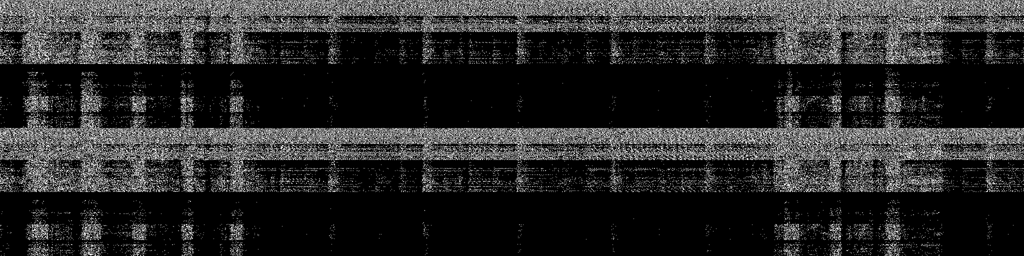

In [16]:
ToPILImage()(X[0]).resize((1024,256))

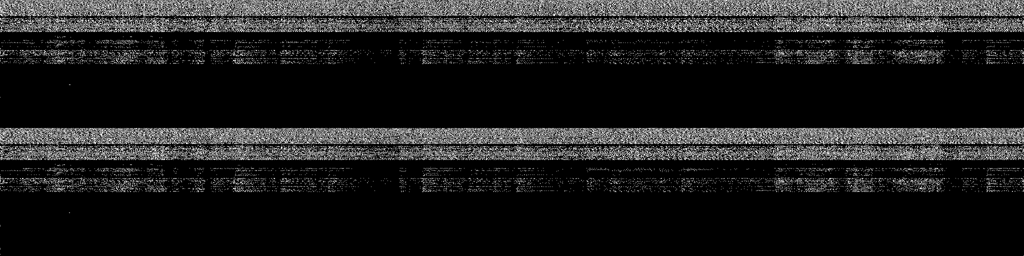

In [17]:
ToPILImage()(Y[0]).resize((1024,256))

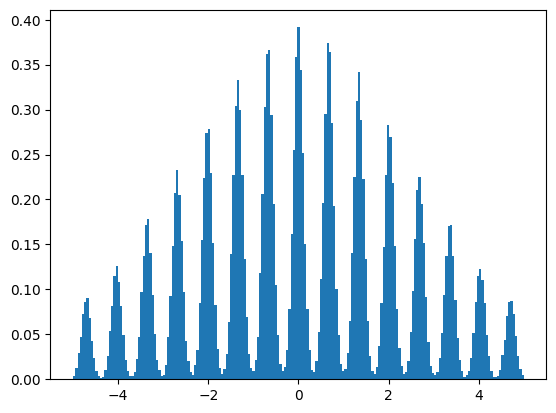

In [18]:
plt.hist(Z.to("cpu").flatten().numpy(), density=True,range=(-5,5),bins=201);

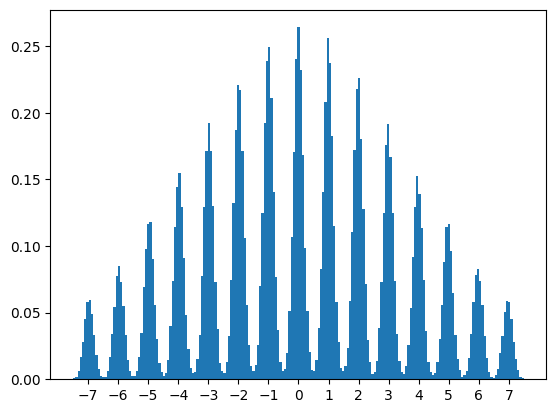

In [19]:
plt.hist(codec.encoder[1](Z).to("cpu").flatten().numpy(), density=True,range=(-7.5,7.5),bins=201);
plt.xticks(range(-7,8));

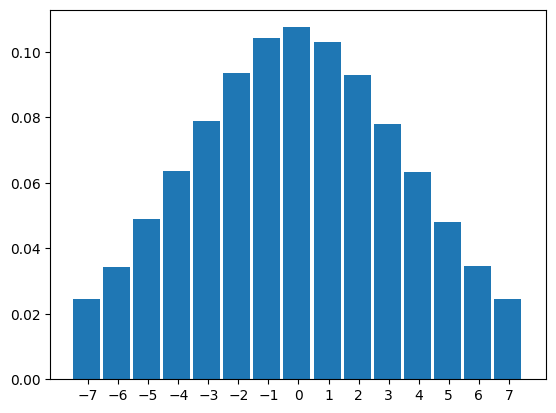

In [20]:
plt.hist(Z2.to("cpu").round().flatten().numpy(), density=True,range=(-7.5,7.5),bins=15,width=0.9);
plt.xticks(range(-7,8));